# Project: missing migrants

## Import Packages 

In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import contextily as cx
from sklearn.cluster import DBSCAN
import plotly.io as pio
import plotly.express as px
import matplotlib.colors as colors

## Functions

In [2]:
def continent(region, asia, america, africa):
    continent=region
    if region in asia:
        continent='Asia'
    if region in america:
        continent='America'
    if region in africa:
        continent='Africa'
    return continent

In [3]:
def quality(source):
    quality='moderate'
    if source in [1,2]:
        quality='bad'
    elif source in [4,5]:
        quality='good'
    return quality

## Issue 

<b> where migrants are most in distress during their journey between 2016 and 2021 ? </b>

To answer this question, we will analyse the disappearance of migrants from three perspectives:
<ul>
<li>The number of reported incidents by year and continent</li>
<li>The quality of information, as this varies greatly from region to region</li>
<li>The detection of hot spots year by year</li>
</ul>

## Import Data

The data used is from the Missing Migrants Project, which is an initiative implemented since 2014 by the International Organization for Migration (IOM) to document the deaths and disappearances of people in the process of migrating to an international destination.

source :
- https://missingmigrants.iom.int/downloads

In [4]:
missing=gpd.read_file('Missing_Migrants_Global_Figures.geojson', sep=',')

In [5]:
missing.head()

,Main ID,Incident ID,Incident Type,Region of Incident,Incident Date,Incident year,Reported Month,Number of Dead,Minimum Estimated Number of Missing,Total Number of Dead and Missing,...,Region of Origin,Cause of Death,Migration route,Location of death,Information Source,UNSD Geographical Grouping,Article title,Source Quality,URL,geometry
0,2014.MMP00001,2014.MMP00001,Incident,North America,2014-01-06,2014,January,1.0,NaN,1,...,Central America,Mixed or unknown,US-Mexico border crossing,Pima Country Office of the Medical Examiner ju...,Pima County Office of the Medical Examiner (PC...,Northern America,None,5.0,http://humaneborders.info/,POINT (-110.36645 31.65026)
1,2014.MMP00002,2014.MMP00002,Incident,North America,2014-01-12,2014,January,1.0,NaN,1,...,Latin America / Caribbean (P),Mixed or unknown,US-Mexico border crossing,Pima Country Office of the Medical Examiner ju...,Pima County Office of the Medical Examiner (PC...,Northern America,Undocumented Border Crossers 01/01/2014-08/29/...,5.0,None,POINT (-111.73756 31.59713)
2,2014.MMP00003,2014.MMP00003,Incident,North America,2014-01-14,2014,January,1.0,NaN,1,...,Latin America / Caribbean (P),Mixed or unknown,US-Mexico border crossing,Pima Country Office of the Medical Examiner ju...,Pima County Office of the Medical Examiner (PC...,Northern America,Undocumented Border Crossers 01/01/2014-08/29/...,5.0,None,POINT (-113.01125 31.94026)
3,2014.MMP00004,2014.MMP00004,Incident,North America,2014-01-16,2014,January,1.0,NaN,1,...,Central America,Violence,US-Mexico border crossing,"near Douglas, Arizona, USA","Ministry of Foreign Affairs Mexico, Pima Count...",Northern America,Mexico condemns the use of force by a border p...,5.0,http://bit.ly/1qfIw00,POINT (-109.31563 31.50678)
4,2014.MMP00005,2014.MMP00005,Incident,Europe,2014-01-16,2014,January,1.0,0.0,1,...,Northern Africa,Harsh environmental conditions / lack of adequ...,None,Border between Russia and Estonia,EUBusiness (Agence France-Presse),Northern Europe,Sudanese migrant freezes to death in illegal E...,1.0,http://bit.ly/1rTFTjR,POINT (28.00000 59.15510)


## Part I: Global Analysis by year and Continent

### Analysis by continent and year

In [6]:
asia=['Southern Asia', 'South-eastern Asia', 'Southern Asia (P)', 'Central Asia', 'Western Asia', 'Western / Southern Asia (P)',
     'Western / Southern Asia', 'Eastern Asia', 'Western Asia (P)', 'Eastern Asia (P)']
africa=['Northern Africa', 'Sub-Saharan Africa (P)', 'Northern Africa (P)', 'Western Africa', 'Eastern Africa',
       'Sub-Saharan Africa', 'Middle Africa', 'Eastern Africa (P)', 'Western Africa (P)', 'Southern Africa']
america=['Central America', 'Latin America / Caribbean (P)', 'South America', 'Caribbean', 'South America (P)', 'Caribbean (P)',
        'Central America (P)','North America']

In [7]:
missing['Continent of Origin']=missing['Region of Origin'].apply(lambda x : continent(x, asia, america, africa))

In [8]:
missing_continent=missing[missing['Continent of Origin'].isin(['Africa', 'America', 'Asia'])].copy()

In [9]:
missing_year_r=missing_continent[['Incident year','Continent of Origin',
                   'Total Number of Dead and Missing']].groupby(['Incident year','Continent of Origin'], as_index=False).sum()



In [10]:
fig = px.bar(missing_year_r, x="Incident year", y="Total Number of Dead and Missing",
             barmode='group',color="Continent of Origin", labels={"Total Number of Dead and Missing": "Incidents by year",
                                                                 "Incident year": "year"})
fig=fig.update_layout(title="Number of deaths and disappearances by Year and Continent",title_x=0.45)

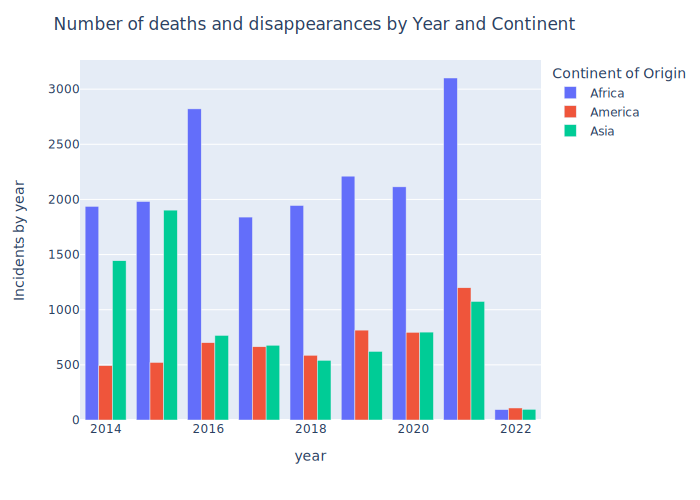

In [11]:
fig.show(renderer="svg")

We can see that the continent with the largest migratory flows is Africa (not counting the unidentified migrants who are mostly in the Mediterranean).
<ul>
<li>For America, we can see that the numbers are quite stable over time with an increase in 2021 related to the resumption of violence in Colombia.</li>
<li>For Asia, the highest numbers occurred in 2014 and 2015 with the Rohingya crisis in Burma.</li>
<li>For Africa, there are two peaks: one in 2016 and the other in 2021.</li>
</ul>

### Focus on Africa

#### what are the migratory flows in Africa?

In [12]:
missing_continent_afr=missing_continent.copy()

In [13]:
missing_continent_afr['Region of Origin']=missing_continent_afr['Region of Origin'].apply(lambda x : x.replace(' (P)', ''))
missing_continent_afr['Region of Incident']=missing_continent_afr['Region of Incident'].apply(lambda x : x.replace(' (P)', ''))

In [14]:
missing_year_africa=missing_continent_afr[['Incident year','Region of Origin',
                   'Total Number of Dead and Missing']].groupby(['Incident year','Region of Origin'], as_index=False).sum()



In [15]:
missing_year_africa=missing_year_africa[missing_year_africa['Region of Origin'].isin(africa)]

In [16]:
fig = px.bar(missing_year_africa, x="Incident year", y="Total Number of Dead and Missing",color="Region of Origin",
             labels={"Total Number of Dead and Missing": "Incidents by year", "Incident year": "year"},
            color_discrete_sequence=px.colors.qualitative.G10)
fig=fig.update_layout(title="Number of deaths and disappearances in Africa",title_x=0.14)

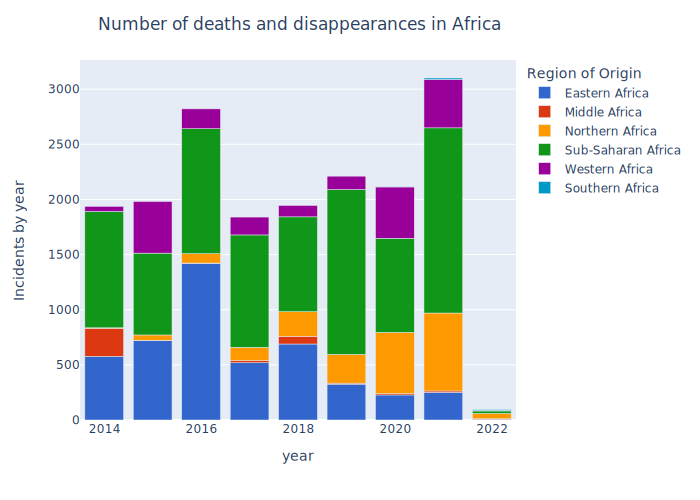

In [17]:
fig.show(renderer="svg")

In 2016, during the first migration peak, the majority of migrants came from Sub-Saharan Africa and East Africa.<br>
Thereafter, the number of migrants from East Africa decreased while the number from Sub-Saharan Africa remained very high.<br>
The second migration peak in 2021 is linked to an increase in the number of migrants from the Northern and Western Africa. This increase is linked to the deterioration of the situation in these areas with the loss of hope of the Algerian population in the face of the almost non-existent changes following the protests in 2019 and the deterioration of the security situation in Mali and Nigeria.


#### but a major bias in analysis is the non-identification of some migrants...

In [18]:
missing_continent_afr2=missing.copy()

In [19]:
missing_continent_afr2['Region of Origin']=missing_continent_afr2['Region of Origin'].apply(lambda x : x.replace(' (P)', ''))
missing_continent_afr2['Region of Incident']=missing_continent_afr2['Region of Incident'].apply(lambda x : x.replace(' (P)', ''))

In [20]:
missing_continent_afr2['Region of Incident'].value_counts()

North America         2203
Northern Africa       1792
Mediterranean         1623
Central America       1010
Southern Asia          968
Western Africa         924
Europe                 463
Eastern Africa         401
Western Asia           311
South-eastern Asia     209
South America          171
Caribbean              108
Middle Africa           72
Southern Africa         10
Eastern Asia             8
Central Asia             1
Name: Region of Incident, dtype: int64

In [21]:
missing_continent_afr2=missing_continent_afr2[missing_continent_afr2['Region of Incident'].isin(['Northern Africa','Mediterranean', 
                                                                                                 'Western Africa', 'Eastern Africa'])].copy()

In [22]:
missing_continent_afr2['Region of Origin']=missing_continent_afr2['Region of Origin'].apply(lambda x : 
                                                                                            continent(x, asia, america, africa))

In [23]:
missing_continent_afr2=missing_continent_afr2[['Region of Origin', 'Region of Incident',
                   'Total Number of Dead and Missing']].groupby(['Region of Origin', 
                                                                 'Region of Incident'], as_index=False).sum()


In [24]:
missing_continent_afr2=missing_continent_afr2[missing_continent_afr2['Total Number of Dead and Missing']>10].copy()

In [25]:
missing_continent_afr2=missing_continent_afr2.sort_values(by=['Region of Origin'], ascending=False)

In [26]:
color_discrete_map = {'Unknown': 'rgb(105,105,105)', 'Mixed': 'rgb(192,192,192)', 
                       'Africa': 'rgb(205,174,136)', 'Asia':  'rgb(0, 206, 209)'}

In [91]:
fig = px.bar(missing_continent_afr2, x="Region of Incident", y="Total Number of Dead and Missing",color="Region of Origin",
             labels={"Total Number of Dead and Missing": "Incidents in thousand"},
            color_discrete_map=color_discrete_map)
fig=fig.update_layout(title="Number of deaths and disappearances without <br> precise identification of the area of origin",title_x=0.2)

In [92]:
fig.show(renderer="html")

ValueError: 
Invalid named renderer(s) received: ['html']

It can be observed that more than half of the cases in the Mediterranean and more than a quarter of the cases in Northern Africa are not associated with a specific geographical area. <br>
Our analysis may therefore be quite far from reality...

## Part II: Source Quality

In [29]:
missing['Source Quality'].value_counts()

2.0    2949
4.0    2377
5.0    2336
1.0    1358
3.0    1214
Name: Source Quality, dtype: int64

In [30]:
missing['quality_b']=missing['Source Quality'].apply(lambda x : quality(x))

In [31]:
missing_qua=missing[missing['quality_b'].isin(['good', 'bad'])].copy()

### clustering quality since 2019

This analysis starts only from 2019 because the quality of the process of the organization could be not so good the first years of project.

In [32]:
missing_qua['long']=missing_qua.geometry.x
missing_qua['lat']=missing_qua.geometry.y
missing_qua=missing_qua[~missing_qua.long.isna()].copy()

In [33]:
missing_qua_recent=missing_qua[missing_qua['Incident year'].isin([2019, 2020, 2021, 2022])]

#### good quality cluster

In [34]:
missing_qua_good=missing_qua_recent[missing_qua_recent['quality_b']=='good'].copy()

In [35]:
coordinates=missing_qua_good[['long', 'lat']].to_numpy()

In [36]:
model=DBSCAN(eps=250/6371., min_samples=30, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))

In [37]:
labels=model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
perc_noise=n_noise_/len(missing_qua_good)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("percentage of noise: " + str(round(perc_noise,2)))
print("size: " + str(len(missing_qua_good)))


Estimated number of clusters: 10
Estimated number of noise points: 308
percentage of noise: 0.12
size: 2615


In [38]:
missing_qua_good['cluster']=model.labels_

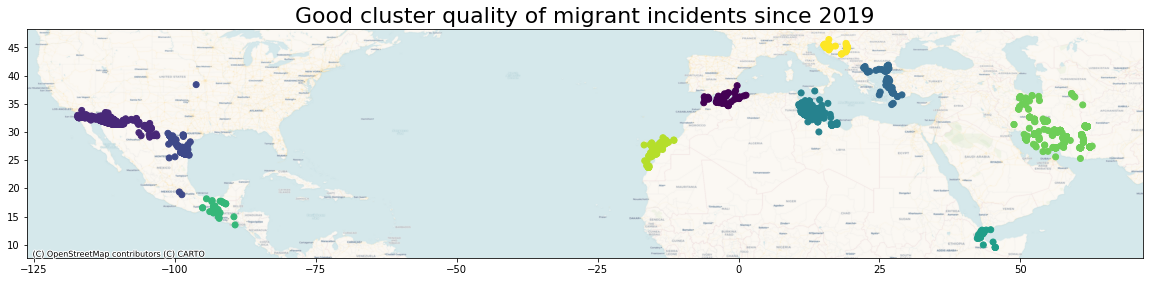

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = missing_qua_good[missing_qua_good['cluster']!=-1].plot(ax=ax,column='cluster')
plt.title("Good cluster quality of migrant incidents since 2019", fontdict={'fontsize': 22, 'fontweight': 'medium'})
cx.add_basemap(ax, crs=missing_qua_good.crs, source=cx.providers.CartoDB.Voyager)

10 geographical areas account for 88% of incidents with good data quality

#### bad quality cluster

In [40]:
missing_qua_bad=missing_qua_recent[missing_qua_recent['quality_b']=='bad'].copy()

In [41]:
coordinates=missing_qua_bad[['long', 'lat']].to_numpy()

In [42]:
model=DBSCAN(eps=250/6371., min_samples=30, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))

In [43]:
labels=model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
perc_noise=n_noise_/len(missing_qua_good)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("percentage of noise: " + str(round(perc_noise,2)))
print("size: " + str(len(missing_qua_bad)))

Estimated number of clusters: 11
Estimated number of noise points: 589
percentage of noise: 0.23
size: 1504


In [44]:
missing_qua_bad['cluster']=model.labels_

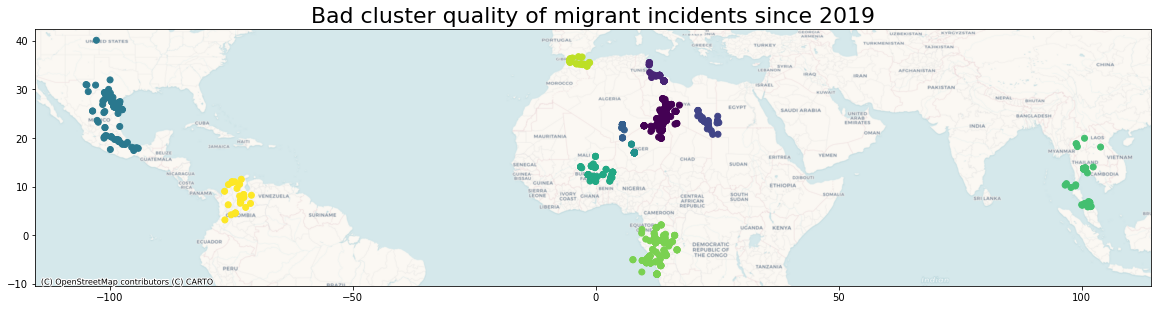

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = missing_qua_bad[missing_qua_bad['cluster']!=-1].plot(ax=ax,column='cluster')
plt.title("Bad cluster quality of migrant incidents since 2019", fontdict={'fontsize': 22, 'fontweight': 'medium'})
cx.add_basemap(ax, crs=missing_qua_bad.crs, source=cx.providers.CartoDB.Voyager)

11 geographical areas account for 77% of incidents with bad data quality, this slightly lower result than the good quality clusters is partly due to the poor quality of information in isolated areas 

#### comparison good and bad quality cluster

In [46]:
missing_qua_bad_c=missing_qua_bad[missing_qua_bad['cluster']!=-1]
missing_qua_good_c=missing_qua_good[missing_qua_good['cluster']!=-1]

In [47]:
missing_qua_bad_c=missing_qua_bad_c.drop_duplicates('geometry')


In [48]:
missing_qua_bad_unary=missing_qua_bad_c.dissolve(by='cluster')

In [49]:
missing_qua_good_unary=missing_qua_good_c.dissolve(by='cluster')

In [50]:
quality_good_bad=gpd.GeoDataFrame(pd.concat([missing_qua_bad_unary, missing_qua_good_unary]))

In [51]:
quality_good_bad=quality_good_bad.reset_index()

In [52]:
quality_good_bad=quality_good_bad.sort_values('quality_b', ascending=False)

In [53]:
color_dict = {'bad':'#7a1d11', 'good':'#42bd56'}

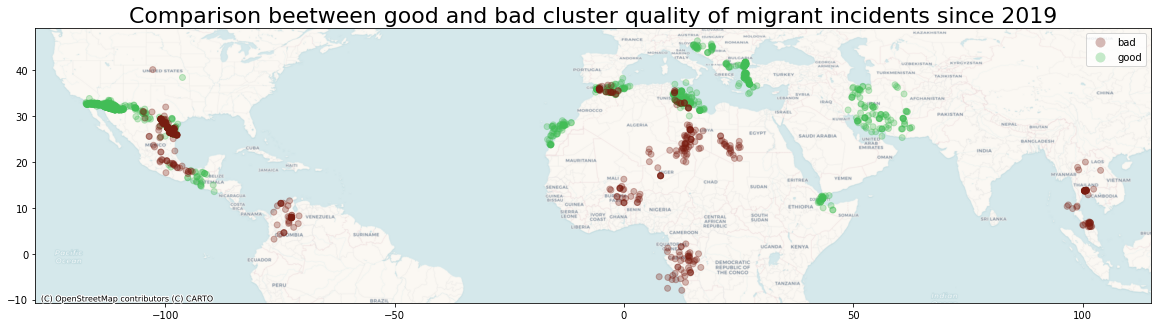

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = quality_good_bad.plot(ax=ax,column='quality_b', legend=True,alpha=0.3, legend_kwds={ 'bbox_to_anchor': (1, 1)},
                          cmap=colors.ListedColormap(list(color_dict.values())))
plt.title("Comparison beetween good and bad cluster quality of migrant incidents since 2019", fontdict={'fontsize': 22, 'fontweight': 'medium'})
cx.add_basemap(ax, crs=quality_good_bad.crs, source=cx.providers.CartoDB.Voyager)

It can be observed that on the borders with Western countries, the incidents are fairly well documented, while the further away from the latter, the more we find areas where information is poorly relayed.
Exceptions to this rule are:
<ul>
    <li>The Texas-Mexico border where information is of poor quality</li>
    <li>the interior of Mexico, where information is also of poor quality</li>
    <li>In Melilla and Ceuta, Spanish enclaves in Morocco, there are overlapping clusters of good and bad information</li> 
    <li>On the contrary, in Iran and the Red Sea, information is of good quality despite the authoritarian regimes</li>
</ul>   
One may wonder about the political will of some states to obstruct information on the fate of migrants...

## Quantitative Comparison beetween 2016-2017 and 2020-2021

### Analysis 2016-2017

In [55]:
missing_continent_1617=missing_continent[missing_continent['Incident year'].isin([2016, 2017])].copy()

In [56]:
missing_continent_1617['long']=missing_continent_1617.geometry.x
missing_continent_1617['lat']=missing_continent_1617.geometry.y
missing_continent_1617=missing_continent_1617[~missing_continent_1617.long.isna()].copy()

In [57]:
coordinates=missing_continent_1617[['long', 'lat']].to_numpy()

In [58]:
model=DBSCAN(eps=200/6371., min_samples=30, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))

In [59]:
labels=model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
perc_noise=n_noise_/len(missing_continent_1617)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("percentage of noise:" + str(round(perc_noise,2)))

Estimated number of clusters: 11
Estimated number of noise points: 540
percentage of noise:0.28


In [60]:
missing_continent_1617['cluster']=model.labels_

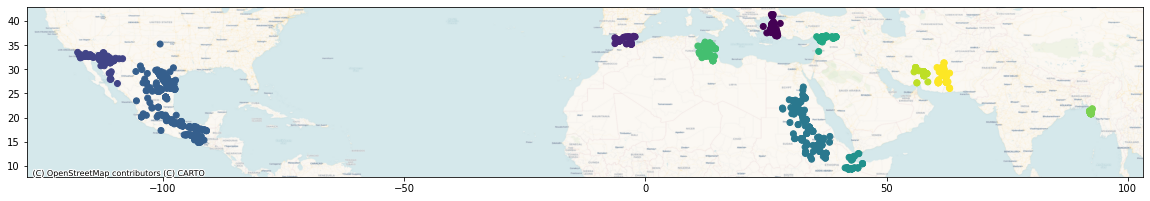

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = missing_continent_1617[missing_continent_1617['cluster']!=-1].plot(ax=ax,column='cluster')
cx.add_basemap(ax, crs=missing_continent_1617.crs, source=cx.providers.CartoDB.Voyager)

### Analysis 2020-2021

In [62]:
missing_continent_2021=missing_continent[missing_continent['Incident year'].isin([2020, 2021])].copy()

In [63]:
missing_continent_2021['long']=missing_continent_2021.geometry.x
missing_continent_2021['lat']=missing_continent_2021.geometry.y
missing_continent_2021=missing_continent_2021[~missing_continent_2021.long.isna()].copy()

In [64]:
coordinates=missing_continent_2021[['long', 'lat']].to_numpy()

In [65]:
model=DBSCAN(eps=200/6371., min_samples=30, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))

In [66]:
labels=model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
perc_noise=n_noise_/len(missing_continent_2021)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("percentage of noise:" + str(round(perc_noise,2)))

Estimated number of clusters: 9
Estimated number of noise points: 484
percentage of noise:0.17


In [67]:
missing_continent_2021['cluster']=model.labels_

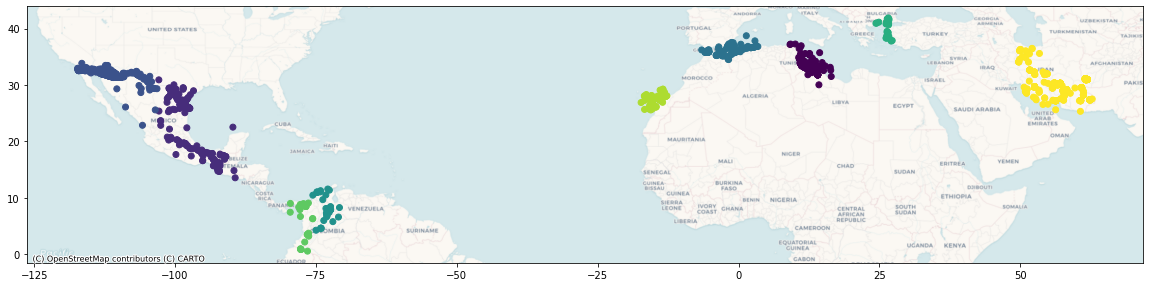

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = missing_continent_2021[missing_continent_2021['cluster']!=-1].plot(ax=ax,column='cluster')
cx.add_basemap(ax, crs=missing_continent_2021.crs, source=cx.providers.CartoDB.Voyager)

#### comparison

In [69]:
cluster_1617=missing_continent_1617[missing_continent_1617['cluster']!=-1].dissolve('cluster')

In [70]:
cluster_1617['geometry']=cluster_1617['geometry'].apply(lambda x: x.convex_hull)

In [71]:
cluster_2021=missing_continent_2021[missing_continent_2021['cluster']!=-1].dissolve('cluster')

In [72]:
cluster_2021['geometry']=cluster_2021['geometry'].apply(lambda x: x.convex_hull)

##### intersection cluster 16_17 and 20_21

In [73]:
intersect_cluster=gpd.overlay(cluster_1617, cluster_2021, how='intersection')

In [74]:
missing_continent_16172021=pd.concat([missing_continent_1617,missing_continent_2021])
missing_continent_16172021=missing_continent_16172021[missing_continent_16172021['cluster']!=-1]

In [75]:
zoning_all_time=gpd.sjoin(missing_continent_16172021, intersect_cluster)

In [76]:
zoning_all_time['year_cluster']='2016-2017 and 2020-2021'

In [77]:
only_1617=missing_continent_1617[~missing_continent_1617.isin(zoning_all_time['Incident ID'].tolist())].copy()

In [78]:
only_1617=only_1617[only_1617['cluster']!=-1]

In [79]:
only_1617['year_cluster']='2016-2017'

In [80]:
only_2021=missing_continent_2021[~missing_continent_2021.isin(zoning_all_time['Incident ID'].tolist())].copy()

In [81]:
only_2021=only_2021[only_2021['cluster']!=-1]

In [82]:
only_2021['year_cluster']='2020-2021'

In [83]:
all_clusters=pd.concat([only_1617,only_2021, zoning_all_time])

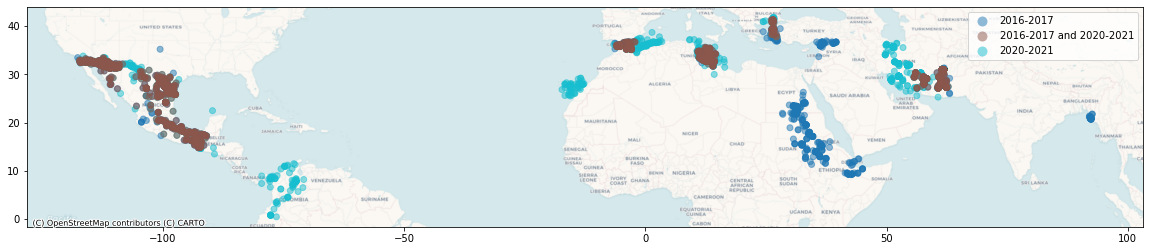

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = all_clusters.plot(ax=ax,column='year_cluster', legend=True,alpha=0.5, legend_kwds={ 'bbox_to_anchor': (1, 1)},
                        )
cx.add_basemap(ax, crs=all_clusters.crs, source=cx.providers.CartoDB.Voyager)